# Advanced Examples of Sequence Space Jacobians in HARK

This notebook has additional examples of the kinds of things you can do with HARK's sequence space Jacobian (SSJ) constructor functionality. If you don't know anything at all about that, we recommend you read the SSJ tutorial notebook first, or even the notebook that explains what an SSJ is.

In [1]:
# First, let's import some basic things and define a plotting function
from time import time
import matplotlib.pyplot as plt

# Define a simple function for plotting SSJs
def plot_SSJ(jac, S, outcome, shock):
    if type(S) is int:
        S = [S]
    for s in S:
        plt.plot(jac[:, s], "-", label="s=" + str(s))
    plt.legend()
    plt.xlabel(r"time $t$")
    plt.ylabel("rate of change of " + outcome)
    plt.title("SSJ for " + outcome + " with respect to " + shock + r" at time $s$")
    plt.tight_layout()
    plt.xlim(-1, jac.shape[0]+1)
    plt.show()

## Using Alternative Constructors

Each `AgentType` subclass is specified to work "off the shelf", with default constructors that build complex model objects (like the distribution of income shocks) from primitive parameters. But what if you want to make (e.g.) different distributional assumptions, or build in additional capabilities? In this example, we walk you through how to do that.

Suppose you're interested in the `IndShockConsumerType` model, but the macroeconomic framework in which your consumers will live has variable wage rates. The wage rate doesn't appear in the `ConsIndShock` model, and the default constructor for `IncShkDstn` doesn't have a wage rate either. However, HARK already has a small extension of the `IncShkDstn` constructor, which *does* have a wage rate built in. Let's make an instance of `IndShockConsumerType` that uses that alternative constructor, then construct SSJs for it.

In [2]:
# Import our AgentType subclass and alternative constructor
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType, IndShockConsumerType_constructors_default
from HARK.Calibration.Income.IncomeProcesses import construct_HANK_lognormal_income_process_unemployment

# Substitute the new constructor into the base constructor dictionary
my_constructors = IndShockConsumerType_constructors_default.copy()
my_constructors["IncShkDstn"] = construct_HANK_lognormal_income_process_unemployment

# Make a parameter dictionary with the new / updated parameters for that constructor
some_new_params = {
    "tax_rate" : [0.0],
    "labor" : [1.0],
    "wage" : [1.0],
    "constructors" : my_constructors
}

# Make an AgentType instance with our alternative constructor
IndShkTypeWithWage = IndShockConsumerType(cycles=0, **some_new_params)

In [3]:
# Make grid specifications
assets_grid_spec = {"min": 0.0, "max": 40.0, "N": 401}
consumption_grid_spec = {"min": 0.0, "max": 5.0, "N": 151}
my_basic_grid_specs = {"kNrm": assets_grid_spec, "cNrm": consumption_grid_spec}

# Make SSJs for asset holdings and consumption with respect to interest factor and wage rate
t0 = time()
SSJ_K_r, SSJ_C_r = IndShkTypeWithWage.make_basic_SSJ("Rfree", ["aNrm", "cNrm"], my_basic_grid_specs, norm="PermShk")
SSJ_K_w, SSJ_C_w = IndShkTypeWithWage.make_basic_SSJ("wage", ["aNrm", "cNrm"], my_basic_grid_specs, norm="PermShk")
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

Constructing those SSJs took 18.855 seconds in total.


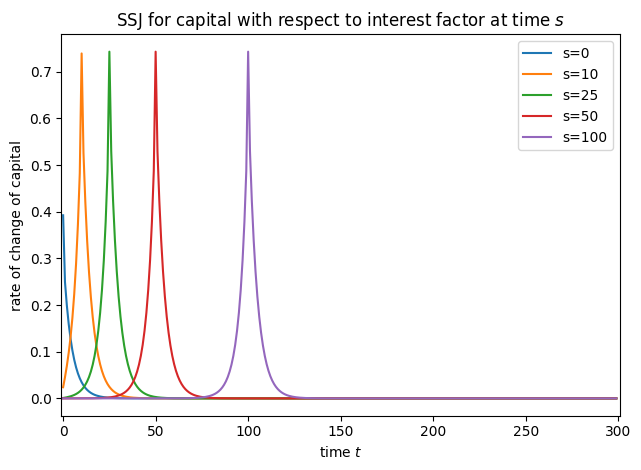

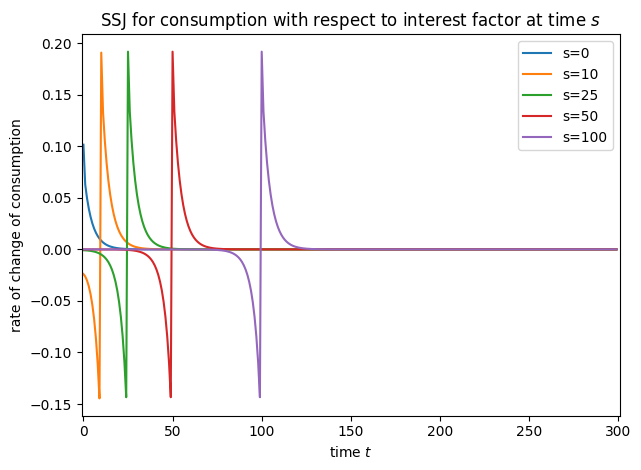

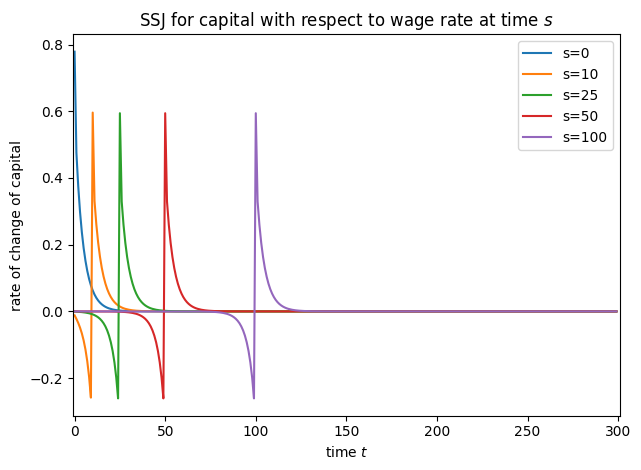

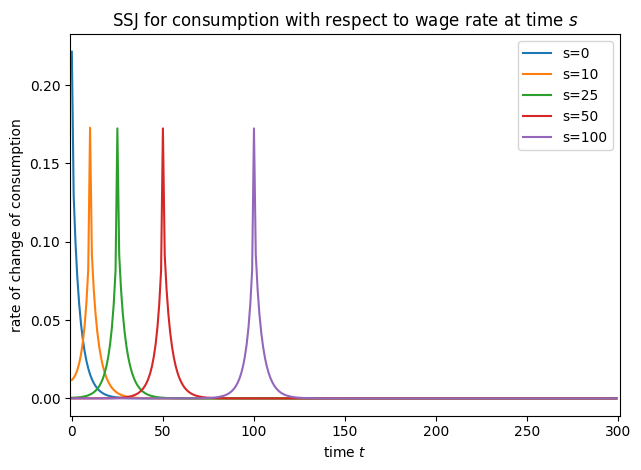

In [4]:
# Plot some slices of the SSJs
plot_SSJ(SSJ_K_r, [0, 10, 25, 50, 100], "capital", "interest factor")
plot_SSJ(SSJ_C_r, [0, 10, 25, 50, 100], "consumption", "interest factor")
plot_SSJ(SSJ_K_w, [0, 10, 25, 50, 100], "capital", "wage rate")
plot_SSJ(SSJ_C_w, [0, 10, 25, 50, 100], "consumption", "wage rate")

In fact, the `NewKeynesianConsumerType` is simply a variation of `IndShockConsumerType` with this income process substituted in, and *handwritten* methods for computing SSJs for *only* assets and consumption. HARK's new SSJ constructor method should work for (almost) *all* `AgentType` subclasses, and for any simulation output.

## Adding Labor Supply on the Intensive Margin

Now suppose you want to work with a *properly* new Keynesian macroeconomic environment, so that agents can vary the intensity of their labor supply depending on the wage rate (and their personal circumstances). The `LaborIntMargConsumerType` does just that, so let's work with it.

In [9]:
# Import and create an agent who chooses labor on the intensive margin
from HARK.ConsumptionSaving.ConsLaborModel import LaborIntMargConsumerType
LaborSupplyType = LaborIntMargConsumerType(cycles=0)

# Make grid specifications
assets_grid_spec = {"min": 0.0, "max": 40.0, "N": 401}
labor_grid_spec = {"min": 0.0, "max": 2.0, "N": 201}
my_labor_grid_specs = {"kNrm": assets_grid_spec, "LbrEff": labor_grid_spec}

In [10]:
# Construct SSJs for capital and labor with respect to the interest factor and the wage rate
t0 = time()
SSJ_K_r, SSJ_L_r = LaborSupplyType.make_basic_SSJ("Rfree", ["aNrm", "LbrEff"], my_labor_grid_specs, norm="PermShk")
SSJ_K_w, SSJ_L_w = LaborSupplyType.make_basic_SSJ("WageRte", ["aNrm", "LbrEff"], my_labor_grid_specs, norm="PermShk", solved=True)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

Constructing those SSJs took 89.009 seconds in total.


Notice that the second time `make_basic_SSJ` is called, the argument `solved=True` is also passed. This is because the long run model is the same no matter what, so once it has been solved once (in the first call), we don't need to re-solve it.

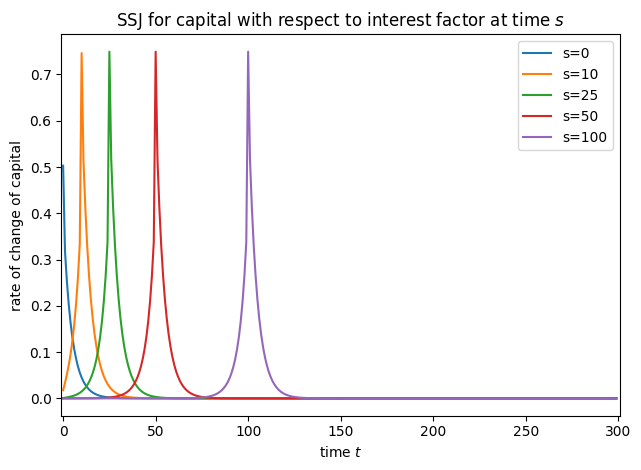

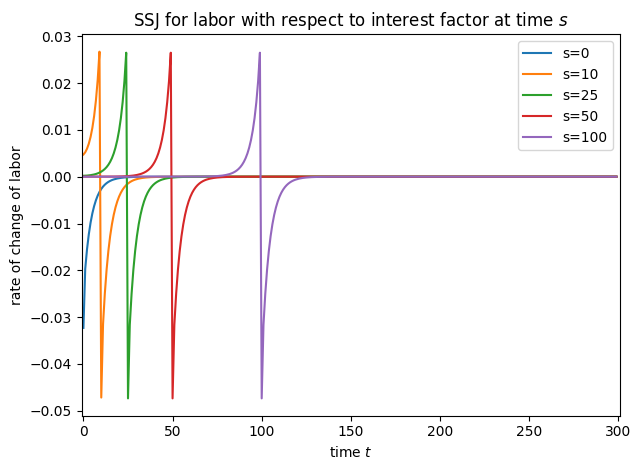

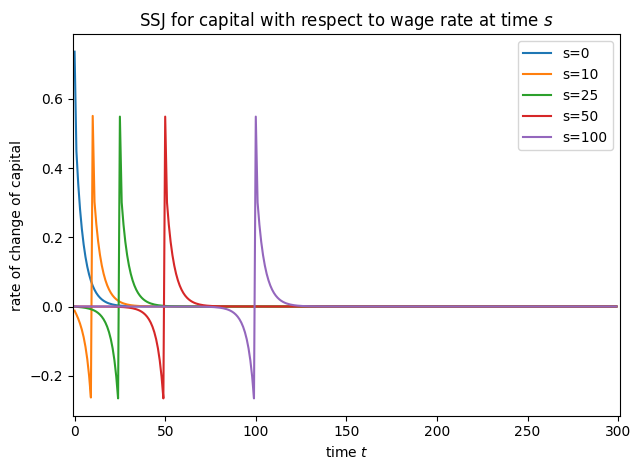

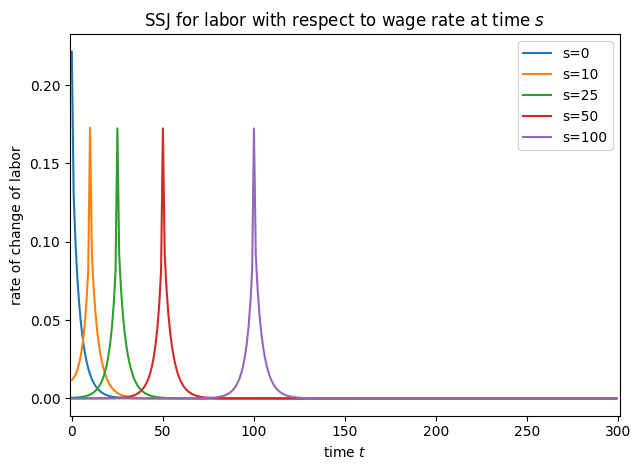

In [11]:
# Plot some slices of the SSJs
plot_SSJ(SSJ_K_r, [0, 10, 25, 50, 100], "capital", "interest factor")
plot_SSJ(SSJ_L_r, [0, 10, 25, 50, 100], "labor", "interest factor")
plot_SSJ(SSJ_K_w, [0, 10, 25, 50, 100], "capital", "wage rate")
plot_SSJ(SSJ_C_w, [0, 10, 25, 50, 100], "labor", "wage rate")

## Implementing Unemployment Dynamics

Now suppose you're interested in a model in which agents can be *persistently* unemployed, transitioning between employment and unemployment with known probabilities. In your macroeconomic environment, these transition probabilities might be determined endogenously, but from the perspective of one individual agent, they treat them as given.

HARK can handle this kind of model using its `MarkovConsumerType`, which adds a discrete state on top of the `IndShockConsumerType` model. Several model objects can depend on the discrete state: survival probabilities, the income shock distribution, the interest factor, and expected permanent income growth. Let's make an instance of `MarkovConsumerType` with two discrete states, one for unemployment (zero labor income) and the other for employment, that are otherwise identical. Conveniently, the default constructor for `MrkvArray` (the transition probabilities) is `make_simple_binary_markov`, so we don't have to change much.

Let's say that discrete state `z=0` means unemployment and state `z=1` means employment. The default `IncShkDstn` constructor for `MarkovConsumerType` is called `construct_markov_lognormal_income_process_unemployment`; it expects to get inputs for `PermShkStd`, `TranShkStd`, `UnempPrb`, and `IncUnemp` as they vary by discrete state `z`. We also need to make sure the discrete states don't vary in any other way, and to set the persistence of (un)employment in the long run.

In [40]:
# Import our agent type
import numpy as np
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.distributions import DiscreteDistributionLabeled

# Specify parameters that differ from defaults
my_markov_params = {
    "PermShkStd" : np.array([[0.1, 0.1]]),
    "TranShkStd" : np.array([[0.1, 0.1]]),
    "UnempPrb" : np.array([0.9999, 0.0]),
    "IncUnemp" : np.array([0.0, 0.0]),
    "Mrkv_p11" : [0.75],  # expect to be unemployed for 4 periods
    "Mrkv_p22" : [0.98],  # expect to be employed for 50 periods
    "MrkvPrbsInit": np.array([0.1, 0.9]),
    "PermGroFac": [np.array([1.01, 1.01])],
}

# Define a substitute "unemployed" income distribution because the default constructor doesn't like zero income
UnemployedIncDstn = DiscreteDistributionLabeled(pmv=np.array([1.0]), atoms=np.array([[1.0], [0.0]]), var_names=["PermShk", "TranShk"])

# Make and solve an infinite horizon problem with persistent unemployment
UnempDynType = MarkovConsumerType(cycles=0, **my_markov_params)
UnempDynType.IncShkDstn[0][0] = UnemployedIncDstn
UnempDynType.solve()

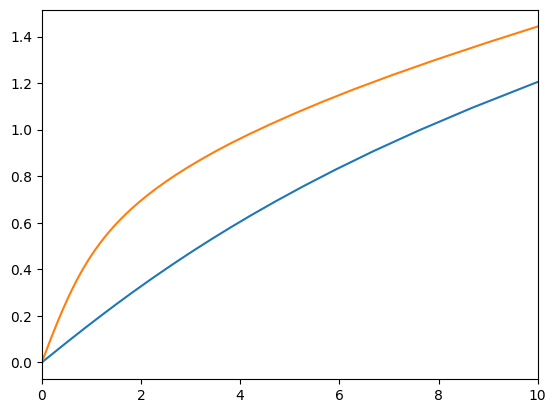

In [41]:
# Plot the state-dependent consumption functions
from HARK.utilities import plot_funcs
UnempDynType.unpack('cFunc')
plot_funcs(UnempDynType.cFunc[0], 0., 10.)

In [44]:
# Make grid specifications
assets_grid_spec = {"min": 0.0, "max": 40.0, "N": 401}
consumption_grid_spec = {"min": 0.0, "max": 2.0, "N": 201}
z_grid = {"N": 2}
my_mrkv_grid_specs = {"kNrm": assets_grid_spec, "cNrm": consumption_grid_spec, "zPrev": z_grid}

# Calculate SSJs with respect to the interest factor and (un)employment flows
t0 = time()
SSJ_K_r, SSJ_C_r = UnempDynType.make_basic_SSJ("Rfree", ["aNrm", "cNrm"], my_mrkv_grid_specs, norm="PermShk", solved=True)
#SSJ_K_UU, SSJ_C_UU = UnempDynType.make_basic_SSJ("Mrkv_p11", ["aNrm", "cNrm"], my_mrkv_grid_specs, norm="PermShk", solved=True)
#SSJ_K_EE, SSJ_C_EE = UnempDynType.make_basic_SSJ("Mrkv_p11", ["aNrm", "cNrm"], my_mrkv_grid_specs, norm="PermShk", solved=True)
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

ValueError: cannot reshape array of size 1 into shape (1,2)